<a href="https://colab.research.google.com/github/kailashkumar-S/kailashkumar-S/blob/main/bs_and_iv_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Estimating the implied volatality of an option using Newton Raphson Method

Three parts to the program:
1. Using GET request to import data
2. Black scholes Model Implementation
3. Calculating implied volatality from the market price of options

**References**:

[AlphaVantage Documentation](https://www.alphavantage.co/documentation/)

[Newton Raphson Method](https://brilliant.org/wiki/newton-raphson-method/)

[py_vollib documentation](https://vollib.org/documentation/1.0.3/autoapi/py_vollib/black_scholes/index.html#module-py_vollib.black_scholes)


In [ ]:
%%capture
! pip install py_vollib

In [ ]:
#Importing the required packages

import ast
import requests
import datetime as dt
import json
import pandas as pd
import numpy as np
import scipy.stats as stats
import plotly as plot
import py_vollib.black_scholes as bs
import py_vollib.black_scholes.greeks.analytical as greeks

In [ ]:
#function to import API key from a txt file
def import_key():
  from google.colab import files
  uploaded = files.upload()
  file = open("Keys.txt", "r")
  keys_dict = ast.literal_eval(file.read())
  file.close()
  return keys_dict['AlphaVantage API key']

api_key = import_key()


Saving Keys.txt to Keys.txt


In [ ]:
#Function to construct the request and get data using API
def get_request(symbol,function,api_key):
  api_url = f"https://www.alphavantage.co/query?function={function}&symbol={symbol}&apikey={api_key}"
  status = requests.get(api_url)
  if status.status_code != 200:
    print("Check URl")
  else:
    return requests.get(api_url).json()

- This API returns the full historical options chain for a specific symbol on a specific date. Implied volatility (IV) and common Greeks are also returned.![newtonRaphsonMethod.png](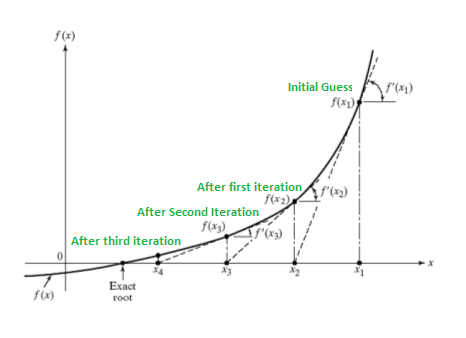![newtonRaphsonMethod.png](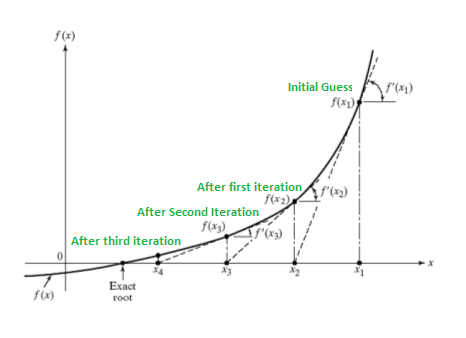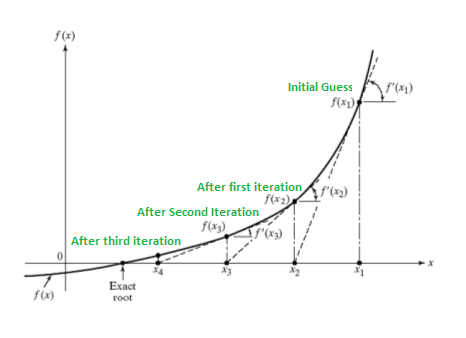))

In [ ]:
data = get_request("SPY","HISTORICAL_OPTIONS",api_key)

- This API returns raw (as-traded) daily time series (date, daily open, daily high, daily low, daily close, daily volume) of the global equity specified

In [ ]:
underlying_data = get_request("SPY","TIME_SERIES_DAILY",api_key)

In [ ]:
option_chain = pd.json_normalize(data['data'])
option_chain[:10]

,contractID,symbol,expiration,strike,type,last,mark,bid,bid_size,ask,ask_size,volume,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho
0,SPY240617C00448000,SPY,2024-06-17,448.00,call,97.51,98.83,98.23,64,99.43,64,6,4,2024-06-17,1.45362,1.00000,0.00000,-0.23875,0.00000,0.01227
1,SPY240617P00448000,SPY,2024-06-17,448.00,put,0.00,0.01,0.00,0,0.01,4165,0,227,2024-06-17,1.24877,-0.00099,0.00009,-0.21808,0.00096,-0.00002
2,SPY240617C00449000,SPY,2024-06-17,449.00,call,98.55,97.83,97.23,65,98.43,65,2,0,2024-06-17,1.43896,1.00000,0.00000,-0.23928,0.00000,0.01230
3,SPY240617P00449000,SPY,2024-06-17,449.00,put,0.00,0.01,0.00,0,0.01,186,0,41,2024-06-17,1.23596,-0.00100,0.00010,-0.21792,0.00097,-0.00002
4,SPY240617C00450000,SPY,2024-06-17,450.00,call,92.67,96.83,96.23,75,97.43,75,11,1005,2024-06-17,1.42429,1.00000,0.00000,-0.23981,0.00000,0.01233
5,SPY240617P00450000,SPY,2024-06-17,450.00,put,0.00,0.01,0.00,0,0.01,186,0,156,2024-06-17,1.22300,-0.00101,0.00010,-0.21744,0.00098,-0.00002
6,SPY240617C00451000,SPY,2024-06-17,451.00,call,0.00,95.84,95.24,66,96.43,66,0,0,2024-06-17,1.40962,1.00000,0.00000,-0.24035,0.00000,0.01235
7,SPY240617P00451000,SPY,2024-06-17,451.00,put,0.00,0.01,0.00,0,0.01,186,0,108,2024-06-17,1.21020,-0.00102,0.00010,-0.21720,0.00098,-0.00002
8,SPY240617C00452000,SPY,2024-06-17,452.00,call,0.00,94.83,94.23,64,95.43,64,0,0,2024-06-17,1.39495,1.00000,0.00000,-0.24088,0.00000,0.01238
9,SPY240617P00452000,SPY,2024-06-17,452.00,put,0.00,0.01,0.00,0,0.01,186,0,0,2024-06-17,1.19739,-0.00103,0.00010,-0.21692,0.00099,-0.00002


In [ ]:
expiration_date = dt.date(2024, 6, 28) # Expiration Date
# Function that calculate the no. of days until expiration from the previous business day
def dates(expiration_date):
  today = dt.datetime.today().date()

  one_day = dt.timedelta(days=1)
  last_business_day = today - one_day
  while last_business_day.weekday() >= 5:
      last_business_day -= one_day
  T = expiration_date - last_business_day
  return today.strftime("%Y-%m-%d"), last_business_day.strftime("%Y-%m-%d"), T.days

today , last_business_day, days = dates(expiration_date)
print("Today's Date:",today,"\nPrevious business Date:",last_business_day,"\nExpiration Date:",expiration_date,"\nDays until expiration:",days)

Today's Date: 2024-06-18 
Previous business Date: 2024-06-17 
Expiration Date: 2024-06-28 
Days until expiration: 11


In [ ]:
options = option_chain[(option_chain["strike"] == "540.00") & (option_chain["expiration"] == expiration_date.strftime("%Y-%m-%d") )]
options

,contractID,symbol,expiration,strike,type,last,mark,bid,bid_size,ask,ask_size,volume,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho
2332,SPY240628C00540000,SPY,2024-06-28,540.00,call,7.93,7.99,7.86,100,8.12,200,37111,39982,2024-06-17,0.03995,0.98293,0.01115,-0.30901,0.04019,0.15966
2333,SPY240628P00540000,SPY,2024-06-28,540.00,put,1.78,1.77,1.76,117,1.78,112,11616,7026,2024-06-17,0.12562,-0.24713,0.02647,-0.55217,0.29997,-0.04128


In [ ]:
underlying_prices = pd.json_normalize(underlying_data['Time Series (Daily)'][last_business_day])
underlying_prices

,1. open,2. high,3. low,4. close,5. volume
0,542.0800,548.5300,541.6072,547.1000,55839457


In [ ]:
closing_price = underlying_prices['4. close'][0]
print(closing_price)

547.1000


### Pricing Call and Put Options using Black Scholes Model
    
- The Black-Scholes model, aka the Black-Scholes-Merton (BSM) model, is a differential equation widely used to price options contracts.

- The Black-Scholes model requires five input variables: the strike price of an option, the current stock price, the time to expiration, the risk-free rate, and the volatility.

- The formula to price call and put options using BSM is as follows:

\begin{align}
\ call \ option = SN(d_{1})-Ke^{-rt}N(d_{2})
\\
\\ put \ option = Ke^{-rt}N(-d_{2}) - SN(-d_{1})
\end{align}

\begin{align}
\\d_{1} = \frac{ln(\frac{S}{K})+ (r+σ^{2}/2)T}{σ\sqrt{T}}
\\d_{1} = \frac{ln(\frac{S}{K})+ (r-σ^{2}/2)T}{σ\sqrt{T}}
\end{align}



*   S - Price of the underlying
*   K - Strike price of the option
*   r - Risk free rate
*   σ - Volatality of in the price of the underlying
*   T - Time period until the expiration of the contract
*   N( ) - is a function that calculates the cumulative probability of a given value in a standard normal distribution.


  

In [ ]:
# Black Scholes Model - Calculate the options price

# define variables

r = 0.0516                    # One year treasury yield as on 14-06-2024
S = float(closing_price)      # Price of the underlying
K = 540.00                    #Strike of the call option
T = days/365                     #The expiration of the contract is on 28-06-2024
sigma = 0.03995               # I have used the implied volatality to calculate value aproximately equal to the market price
option = "call"

def blackscholes(r, S, K, T, sigma, option="call"):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    try:
        if option == "call":
            c = S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
            print("Value of the", option, "option is", c)
        elif option == "put":
            p = K * np.exp(-r * T) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1)
            print("Value of the", option, "option is", p)
        else:
            print("Invalid option type! Please choose 'call' or 'put'.")
    except Exception as e:
        print("An error occurred:", e)


blackscholes(r,S,K,T,sigma,option)

Value of the call option is 7.96293561396908


##Calculating the implied volatality using Newton Raphson method

* The Newton-Raphson method (also known as Newton's method) is a way to quickly find a good approximation for the root of a real-valued function.

* It uses the idea that a continuous and differentiable function can be approximated by a straight line tangent to it.

* The most basic version starts with a real-valued function $f(x)$, its derivative $f′$, and an initial guess $x_0$ for a root of $f$. If $f$ satisfies certain assumptions and the initial guess is close, then

\begin{align}
x_1 = x_0 + \frac{f(x_0)}{f'(x_0)}
\end{align}

* The process is repeated as
\begin{align}
x_{n+1} = x_n + \frac{f(x_n)}{f'(x_n)}
\end{align}

* Here the function $f_x = Calculate Price - Market price$

* The derivative of the function is the vega of the option, as the vega is defined as $\frac{ΔC}{Δσ}$ or $\frac{ΔP}{Δσ}$

*The new estimated volatality is given by
\begin{align}
\sigma_{\text{new}} = \sigma_{\text{old}} - \frac{(BS_{\sigma_{\text{old}}}) - (\text{market price})}{\text{vega}_{σ_{old}}}
\end{align}

![picture](https://media.geeksforgeeks.org/wp-content/cdn-uploads/newtonRaphsonMethod.png)

In [ ]:
options = option_chain[(option_chain["strike"] == "540.00") & (option_chain["expiration"] == expiration_date.strftime("%Y-%m-%d") )]
options[options["type"]=="call"]

,contractID,symbol,expiration,strike,type,last,mark,bid,bid_size,ask,ask_size,volume,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho
2332,SPY240628C00540000,SPY,2024-06-28,540.00,call,7.93,7.99,7.86,100,8.12,200,37111,39982,2024-06-17,0.03995,0.98293,0.01115,-0.30901,0.04019,0.15966


In [ ]:
# define variables
r = 0.0516                # One year treasury yield as on 14-06-2024
S = float(closing_price)  # Price of the underlying
K = 540.00                # Strike Price of the  option
T = days / 365            # The expiration of the contract is on 21-06-2024
sigma = 0.05
market_price = 7.99
flag = "c"                #Flag set to C for call option

def calculate_implied_volatility(flag, market_price, S, K, t, r, sigma, tol=0.0001, max_iter=25):  # Using Newton-Raphson method
    for n in range(max_iter):
      calculated_price = bs.black_scholes(flag, S, K, t, r, sigma) # Using vollib method
      print("Price of the option calculated after",n+1,"iteration",calculated_price)
      f_n = calculated_price - market_price
      vega = greeks.vega(flag, S, K, t, r,sigma)*100 # Using vollib method
      if vega == 0.00:
        break
      sigma_new = sigma - (f_n/vega)
      if abs(sigma_new - sigma) < tol or abs(f_n) < tol:
        break
      sigma = sigma_new
    return sigma

# Calculate implied volatility
implied_volatility = calculate_implied_volatility(flag, market_price, S, K, T, r, sigma)
print("\nEstimated volatality is:",implied_volatility)



Price of the option calculated after 1 iteration 8.028705606054473
Price of the option calculated after 2 iteration 7.994668539596817
Price of the option calculated after 3 iteration 7.990116428129631

Estimated volatality is: 0.04507620497874171
